1. Import Libraries

In [17]:
# Import Libraries
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from PIL import Image

from google.colab import drive
drive.mount('/content/gdrive')

!ls -l ./gdrive/MyDrive/Colab\ Notebooks/datasets

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
total 164295
-rw------- 1 root root     23875 Oct 17 04:57 diabetes2.csv
-rw------- 1 root root     30623 Dec 12 23:24 sample-submission.csv
-rw------- 1 root root     26657 Dec 15 00:16 submission.csv
-rw------- 1 root root  33075636 Nov 18 08:26 test_data.csv
-rw------- 1 root root 135047556 Nov 18 08:26 train_data.csv
-rw------- 1 root root     32350 Dec 12 23:26 train_target.csv


Select Device

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


2. Make Datasets

In [19]:
# Load data
train_data = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/datasets/train_data.csv', header=None)
train_target = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/datasets/train_target.csv', header=None)
test_data = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/datasets/test_data.csv', header=None)

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = data
        self.target = target
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Load image data, reshape, and convert to PIL Image
        image = self.data.iloc[idx, :].values.astype(np.uint8).reshape(48, 48)
        image = Image.fromarray(image)
        target = self.target.iloc[idx, 0]

        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)

        return image, target

# Define transformations for the data
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert image to grayscale
    transforms.ToTensor()  # Convert image to PyTorch tensor
])

# Define transformations for the data with augmentation
transform_with_augmentation = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(15),  # Randomly rotate the image up to 15 degrees
    transforms.RandomResizedCrop(48, scale=(0.8, 1.0), ratio=(0.8, 1.2)),  # Randomly crop and resize
    transforms.ToTensor()
])

# Create datasets and dataloaders
X_train, X_val, y_train, y_val = train_test_split(train_data, train_target, test_size=0.2, random_state=42)

# Create datasets and dataloaders with data augmentation
train_dataset_with_augmentation = CustomDataset(X_train, y_train, transform=transform_with_augmentation)
val_dataset = CustomDataset(X_val, y_val, transform=transform)
test_dataset = CustomDataset(test_data, pd.DataFrame(np.zeros((len(test_data), 1))), transform=transform)

# Create dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset_with_augmentation, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Display Sample Image

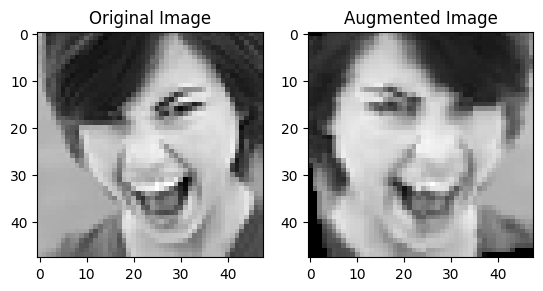

In [20]:
# Display original and augmented images
original_image = X_train.iloc[0, :].values.astype(np.uint8).reshape(48, 48)
augmented_image = transform_with_augmentation(Image.fromarray(original_image))

plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(augmented_image.squeeze(), cmap='gray')
plt.title('Augmented Image')

plt.show()


3. Make CNN Classes

In [21]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(CNNBlock, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection if dimensions change
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x

        # Forward pass through the first convolutional block
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        # Forward pass through the second convolutional block
        x = self.conv2(x)
        x = self.bn2(x)

        # Skip connection (shortcut)
        x += self.shortcut(residual)
        x = self.relu(x)

        return x

class CNNModel(nn.Module):
    def __init__(self, block, layers, num_classes=3):
        super(CNNModel, self).__init__()

        self.in_channels = 32  # Initial input channels
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        # Define layers with make_layer function
        self.layer1 = self.make_layer(block, 32, layers[0], stride=1)
        self.layer2 = self.make_layer(block, 64, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 128, layers[2], stride=2)

        # Global average pooling and fully connected layer for classification
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)

    def make_layer(self, block, out_channels, blocks, stride):
        layers = []

        # Create the first block of the layer with the specified stride
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels

        # Create the rest of the blocks with stride=1
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels, stride=1))

        return nn.Sequential(*layers)

    def forward(self, x):
        # Forward pass through the network
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)

        # Fully connected layer for classification
        x = self.fc(x)

        return x


4. Training Loop

Epoch 1/15, Training Loss: 1.0507, Training Accuracy: 0.4550, Validation Loss: 1.1891, Validation Accuracy: 0.3586
Epoch 2/15, Training Loss: 0.9063, Training Accuracy: 0.5732, Validation Loss: 0.9635, Validation Accuracy: 0.5323
Epoch 3/15, Training Loss: 0.7443, Training Accuracy: 0.6714, Validation Loss: 0.9038, Validation Accuracy: 0.5679
Epoch 4/15, Training Loss: 0.6812, Training Accuracy: 0.7099, Validation Loss: 0.8703, Validation Accuracy: 0.6093
Epoch 5/15, Training Loss: 0.6364, Training Accuracy: 0.7302, Validation Loss: 0.5855, Validation Accuracy: 0.7583
Epoch 6/15, Training Loss: 0.6052, Training Accuracy: 0.7455, Validation Loss: 0.5910, Validation Accuracy: 0.7397
Epoch 7/15, Training Loss: 0.5822, Training Accuracy: 0.7549, Validation Loss: 0.5898, Validation Accuracy: 0.7626
Epoch 8/15, Training Loss: 0.5552, Training Accuracy: 0.7670, Validation Loss: 0.5318, Validation Accuracy: 0.7827
Epoch 9/15, Training Loss: 0.5449, Training Accuracy: 0.7763, Validation Loss: 0

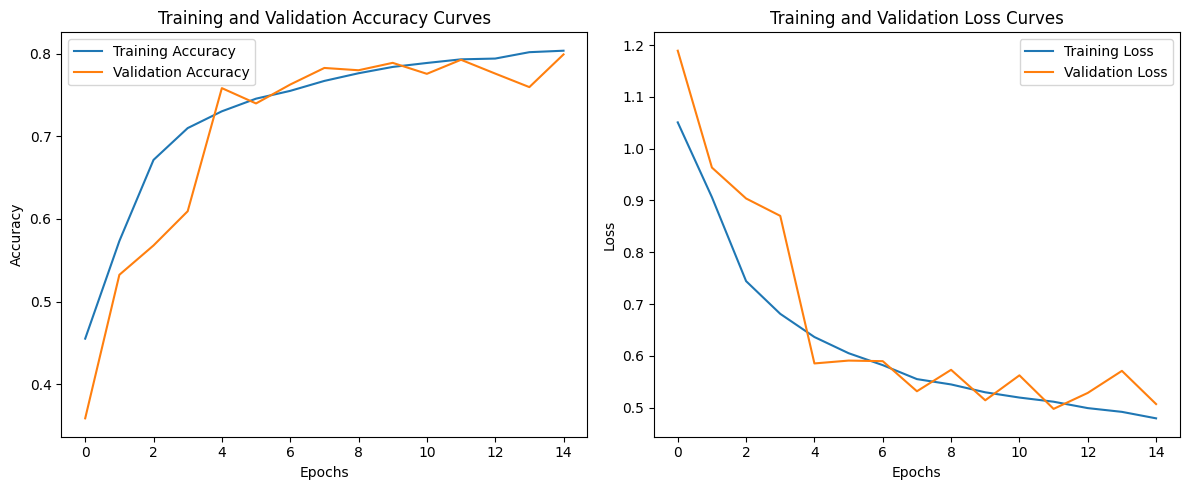

In [22]:
# Set the number of training epochs
num_epochs = 15

# Instantiate the CNN model with 3 sets of 2 residual blocks each
model = CNNModel(CNNBlock, [2, 2, 2]).to(device)

# Define the CrossEntropyLoss criterion and Adam optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create a DataLoader for the training dataset with augmentation
train_loader = torch.utils.data.DataLoader(train_dataset_with_augmentation, batch_size=64, shuffle=True)

# Lists to store training and validation accuracy, as well as training and validation loss
training_accuracy = []
validation_accuracy = []
training_loss = []
validation_loss = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    correct_train = 0
    total_train = 0

    # Iterate over batches in the training DataLoader
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization step
        loss.backward()
        optimizer.step()

        # Update training loss and accuracy metrics
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = correct_train / total_train
    train_loss = epoch_loss / len(train_loader)

    training_accuracy.append(train_accuracy)
    training_loss.append(train_loss)

    val_predictions = []
    val_targets = []

    # Set the model to evaluation mode
    model.eval()

    # Initialize variables to keep track of validation loss and accuracy
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute the loss
            loss = criterion(outputs, labels)

            # Update validation loss and accuracy metrics
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = correct_val / total_val
    val_loss = val_loss / len(val_loader)

    validation_accuracy.append(val_accuracy)
    validation_loss.append(val_loss)

    # Print epoch statistics
    print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()

plt.tight_layout()
plt.show()

5. Validate Model

In [23]:
# Set the model to evaluation mode
model.eval()

val_predictions = []
val_targets = []

with torch.no_grad():
    for inputs, labels in val_loader:
        # Forward pass through the model
        outputs = model(inputs.to(device))

        # Get the predicted classes by selecting the index with the maximum value
        _, predicted = torch.max(outputs, 1)

        # Extend the lists with predicted classes and actual targets
        val_predictions.extend(predicted.cpu().numpy())
        val_targets.extend(labels.cpu().numpy())

val_accuracy = accuracy_score(val_targets, val_predictions)
print(f'Validation Accuracy: {val_accuracy}')


Validation Accuracy: 0.7990726429675425


6. Make Predictions

In [24]:
# Set the model to evaluation mode
model.eval()

test_predictions = []

with torch.no_grad():
    for inputs, _ in test_loader:
        # Forward pass through the model
        outputs = model(inputs.to(device))

        # Get the predicted classes by selecting the index with the maximum value
        _, predicted = torch.max(outputs, 1)

        # Extend the list with predicted classes
        test_predictions.extend(predicted.cpu().numpy())


7. Save Submission (w/histogram)

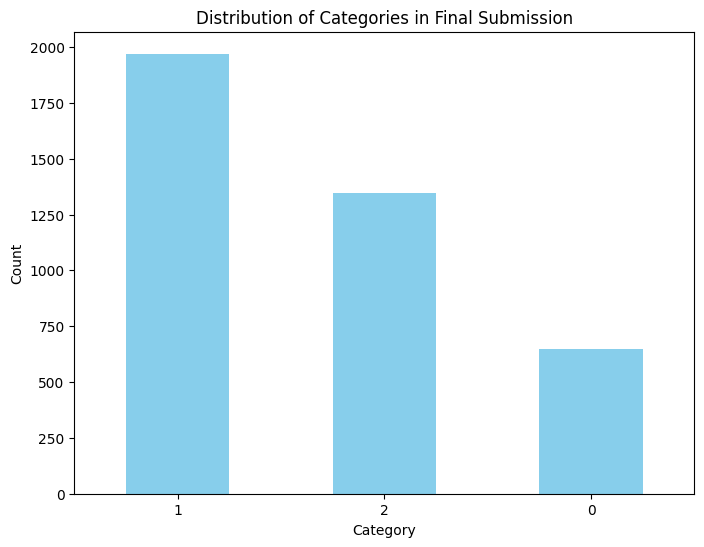

In [25]:
submission_df = pd.DataFrame({'Id': range(len(test_predictions)), 'Category': test_predictions})

# Save the submission DataFrame to a CSV file
submission_df.to_csv('/content/gdrive/MyDrive/Colab Notebooks/datasets/submission.csv', index=False)

categories_histogram = submission_df['Category'].value_counts()

plt.figure(figsize=(8, 6))
categories_histogram.plot(kind='bar', color='skyblue')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Distribution of Categories in Final Submission')
plt.xticks(rotation=0)
plt.show()

8. Final Score

In [26]:
print(f'Final Validation Accuracy: {val_accuracy}')

Final Validation Accuracy: 0.7990726429675425
